In [1]:
#in-sample 1991Jan-2023May or June , out-sample 2023 May/June-2023Dec (120 trading days, less than 1 year)-

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.tsa.stattools import adfuller

# GARCH-MIDAS

Key points:
- Model uses mean-reverting unit daily GARCH process to fit the short-lived component (fast) of the volatility; MIDAS polynomial to depict the secular component driven by some lower frequency variables (slow)


$$r_{i,t} = \mu + \sqrt{\tau_ig_{i,t}}\epsilon_{i,t}, \forall i = 1, 2, ..., N_t$$

whereby
- $r_{i,t}$: price return (log or compound return?)
- $\mu$: mean daily return conditional on information set $\Psi_{i-1}$ 
- $N_t$: number of days in month t
- $g_{i,t}$: short-term component of the conditional probability
- $\tau_t$: secular component


Garch(1,1) process:
$$g_{i,t} = (1 - \alpha - \beta) + \alpha \frac{(r_{i-1,t}-\mu)^2}{\tau_t} + \beta g_{i-1,t}$$


MIDAS regression (which one? hmmm....):
$$\tau_t = m^2 + \underbrace{\theta_R^2 \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

$$log(\tau_t) = m + \underbrace{\theta_R \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

where:
- $RV_t$: realized volatility of daily returns in month $t$
- $K_r$: number of periods over which the realized volatility is smoothed
- $\theta$: measures the contribution of RV to the secular component


Original Study:
- In-sample estimation: January 1, 1991 - December 31, 2021
- Out-sample test: January 1, 2022 - July 29, 2022
- Forecasts in this study were conducted with a rolling-window approach—i.e., using data from January 1, 1991, to December 31,
2021, to project the price volatility on January 1, 2022; using data from January 2, 1991, to January 1, 2022, to project the volatility
on January 2, 2022; and so on.

Further reference:
https://github.com/blake-marsh/GARCH_replication


---

# Data Processing
- Read csvs containing CPU, EMDAT, Futures data

In [3]:
# Climate Policy Uncertainty Index
# source: https://www.policyuncertainty.com/climate_uncertainty.html
cpu = pd.read_csv('cpu.csv', sep=',')

# EM-DAT International disaster database
# Source: https://www.emdat.be/
emdat = pd.read_csv('EMDAT.csv', encoding_errors='ignore')

# Natural Gas Futures price
# Source: https://www.eia.gov/dnav/ng/hist/rngc1d.htm
natgas_futures = pd.read_csv('natgas_futures_price.csv', sep=',')
natgas_futures_bef_1994 = pd.read_csv("ngfutures.csv")

In [4]:
#concatentating the Natural Gas data

start_date = pd.to_datetime("1991-01-01")
end_date = pd.to_datetime("2023-07-01")

natgas_futures_bef_1994['Date']= pd.to_datetime(natgas_futures_bef_1994['Date'],format='%d/%m/%Y')
natgas_futures_bef_1994.set_index('Date', inplace=True)
natgas_futures_bef_1994.rename(columns={"Price": "natgas_future_price"}, inplace=True)

natgas_futures['Date']= pd.to_datetime(natgas_futures['Date'],format='%d/%m/%y')
natgas_futures.set_index('Date', inplace=True)

date_end = pd.to_datetime("1994-01-13")
natgas_future_prior1994 = natgas_futures_bef_1994[(natgas_futures_bef_1994.index.year >= 1991) & (natgas_futures_bef_1994.index <= date_end)]
natgas_futures = pd.concat([natgas_future_prior1994, natgas_futures], axis=0)
natgas_futures = natgas_futures[(natgas_futures.index > start_date) 
                                  &
                              (natgas_futures.index < end_date)]

In [5]:
# Combine Dataframe

# Prepare CPU index data
cpu[['date', 'cpu_index', 'old_cpu_index']] = cpu['date,cpu_index,old_cpu_index'].str.split(',', expand=True)
cpu['date']= pd.to_datetime(cpu['date'],format='%b-%y')
cpu.set_index('date', inplace=True)
cpu.drop(columns=['date,cpu_index,old_cpu_index','old_cpu_index'], inplace=True)
cpu['cpu_index'] = pd.to_numeric(cpu['cpu_index'])

cpu = cpu[(cpu.index >= start_date)
           &
        (cpu.index < end_date)]

# Process EM-DAT data
emdat = emdat[['Country', 'Subregion', 'Region', 
               'Disaster Group', 'Disaster Subgroup', 
               'Disaster Type','Start Year', 'Start Month', 
               'End Year', 'End Month']]
emdat.dropna(inplace=True)

# Key date should be based on the start date of the disaster, when market may react
emdat['Date'] =\
    pd\
    .to_datetime(
        emdat['Start Year'].astype(str) 
        + '-' 
        + emdat['Start Month'].astype(int).astype(str).str.zfill(2))

# Create a df with monthly frequencies as series
emdat_mthly_freq =\
(
    emdat
        .groupby(by = 'Date')
        .count()
        [['Disaster Group']]
        .rename(columns = {'Disaster Group' : 'Monthly_Disaster_Freq'})
)

emdat_mthly_freq = emdat_mthly_freq[(emdat_mthly_freq.index >= start_date)
                                   &
                                   (emdat_mthly_freq.index < end_date)]

# Futures prices
# Log returns rescaled to 100
natgas_futures['daily_return'] =\
np.log(
    natgas_futures['natgas_future_price']/
    natgas_futures['natgas_future_price'].shift()
) 

In [6]:
natgas_futures['daily_return'] 

Date
1991-01-02         NaN
1991-01-03   -0.027672
1991-01-04   -0.022129
1991-01-07    0.023811
1991-01-08    0.000560
                ...   
2023-06-26    0.022465
2023-06-27   -0.010083
2023-06-28   -0.059652
2023-06-29    0.036957
2023-06-30    0.035283
Name: daily_return, Length: 8160, dtype: float64

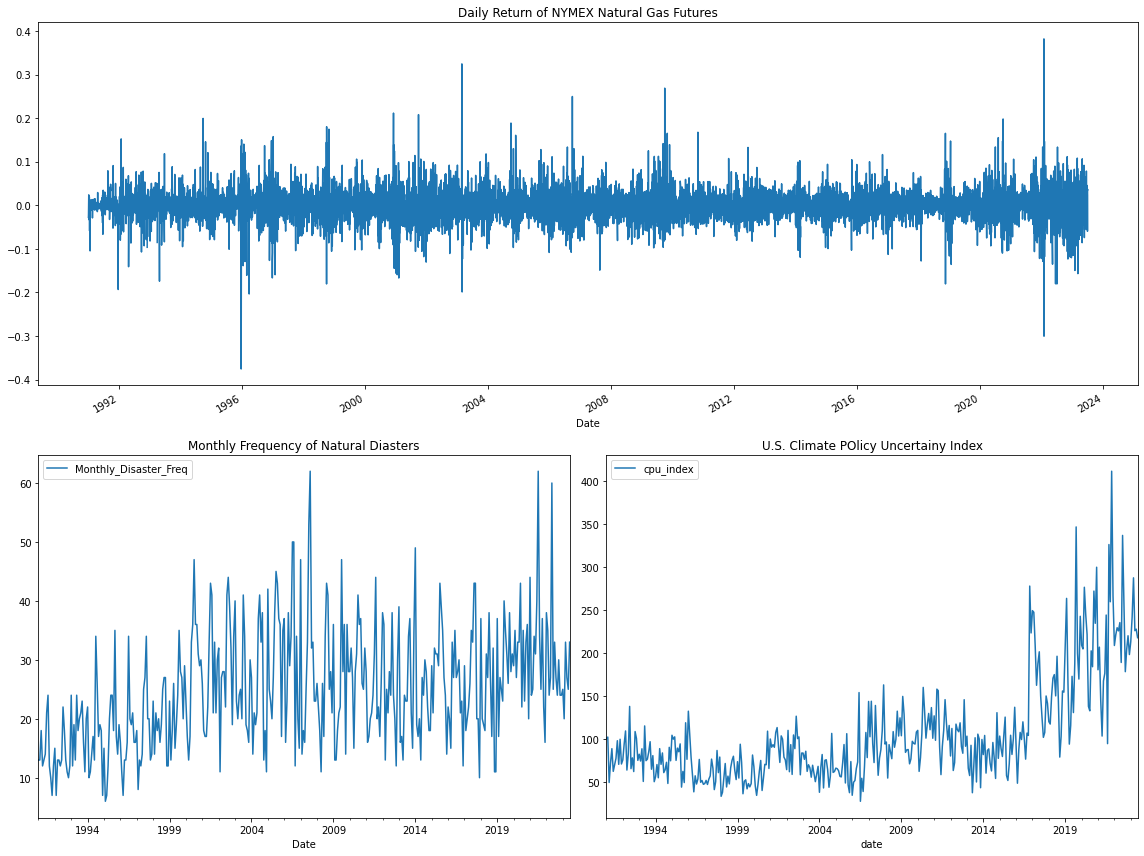

In [7]:
#Descriptive plot, replicating paper's

fig = plt.figure(figsize=(16, 12))

# Define grid size and positions
grid_size = (2, 2)
ax1 = plt.subplot2grid(grid_size, (0, 0), colspan=2)
ax2 = plt.subplot2grid(grid_size, (1, 0))
ax3 = plt.subplot2grid(grid_size, (1, 1))

# Plot each data on respective axes
natgas_futures["daily_return"].plot(ax=ax1)
ax1.set_title('Daily Return of NYMEX Natural Gas Futures')

emdat_mthly_freq.plot(ax=ax2)
ax2.set_title('Monthly Frequency of Natural Diasters')

cpu.plot(ax=ax3)
ax3.set_title('U.S. Climate POlicy Uncertainy Index')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [8]:
#additional df for monthly diff log cpu
diff_ln_cpu = np.log(cpu['cpu_index']).diff().to_frame().rename(columns={"cpu_index" : "diff_ln(cpu)"})
diff_ln_emdat_mthly_freq = np.log(emdat_mthly_freq).diff().rename(columns={"Monthly_Disaster_Freq" : "diff_ln(monthly_disaster_freq)"})


#imputating Nan values with median
natgas_futures["daily_return"].fillna(natgas_futures["daily_return"].median(),inplace = True)
diff_ln_cpu["diff_ln(cpu)"].fillna(diff_ln_cpu["diff_ln(cpu)"].median(),inplace = True)
diff_ln_emdat_mthly_freq["diff_ln(monthly_disaster_freq)"].fillna(diff_ln_emdat_mthly_freq["diff_ln(monthly_disaster_freq)"].median(),inplace = True)


#Descriptive statistics

#obs
obs = pd.DataFrame({"Natural gas futures return (daily)": natgas_futures.shape[0],
              "CPU Index": cpu.shape[0],
             "ln(CPU Index)": diff_ln_cpu.shape[0], 
             "Natural disasters frequency": emdat_mthly_freq.shape[0],
              "ln(Natural disasters frequency)": diff_ln_emdat_mthly_freq.shape[0]}, index = ["Obs"]
             ).T

#Mean
mean = pd.DataFrame({"Natural gas futures return (daily)": natgas_futures["daily_return"].mean(),
              "CPU Index": cpu["cpu_index"].mean(),
             "ln(CPU Index)": diff_ln_cpu["diff_ln(cpu)"].mean(), 
             "Natural disasters frequency": emdat_mthly_freq["Monthly_Disaster_Freq"].mean(),
              "ln(Natural disasters frequency)": diff_ln_emdat_mthly_freq["diff_ln(monthly_disaster_freq)"].mean()}, index = ["Mean"]
             ).T

#std.
std = pd.DataFrame({"Natural gas futures return (daily)": natgas_futures["daily_return"].std(),
              "CPU Index": cpu["cpu_index"].std(),
             "ln(CPU Index)": diff_ln_cpu["diff_ln(cpu)"].std(), 
             "Natural disasters frequency": emdat_mthly_freq["Monthly_Disaster_Freq"].std(),
              "ln(Natural disasters frequency)": diff_ln_emdat_mthly_freq["diff_ln(monthly_disaster_freq)"].std()}, index = ["Std."]
             ).T


#Min
min_ = pd.DataFrame({"Natural gas futures return (daily)": natgas_futures["daily_return"].min(),
              "CPU Index": cpu["cpu_index"].min(),
             "ln(CPU Index)": diff_ln_cpu["diff_ln(cpu)"].min(), 
             "Natural disasters frequency": emdat_mthly_freq["Monthly_Disaster_Freq"].min(),
              "ln(Natural disasters frequency)": diff_ln_emdat_mthly_freq["diff_ln(monthly_disaster_freq)"].min()}, index = ["Min"]
             ).T

#Max
max_ = pd.DataFrame({"Natural gas futures return (daily)": natgas_futures["daily_return"].max(),
              "CPU Index": cpu["cpu_index"].max(),
             "ln(CPU Index)": diff_ln_cpu["diff_ln(cpu)"].max(), 
             "Natural disasters frequency": emdat_mthly_freq["Monthly_Disaster_Freq"].max(),
              "ln(Natural disasters frequency)": diff_ln_emdat_mthly_freq["diff_ln(monthly_disaster_freq)"].max()}, index = ["Max"]
             ).T

#Skewness
skewness = pd.DataFrame({"Natural gas futures return (daily)": stats.skew(natgas_futures["daily_return"]),
              "CPU Index": stats.skew(cpu["cpu_index"]),
             "ln(CPU Index)": stats.skew(diff_ln_cpu["diff_ln(cpu)"]), 
             "Natural disasters frequency": stats.skew(emdat_mthly_freq["Monthly_Disaster_Freq"]),
              "ln(Natural disasters frequency)": stats.skew(
                                                  diff_ln_emdat_mthly_freq["diff_ln(monthly_disaster_freq)"]
                                                            )
                        }, index = ["Skewness"]
                         ).T

#Kurtosis
kurtosis = pd.DataFrame({"Natural gas futures return (daily)": stats.kurtosis(natgas_futures["daily_return"]),
              "CPU Index": stats.kurtosis(cpu["cpu_index"]),
             "ln(CPU Index)": stats.kurtosis(diff_ln_cpu["diff_ln(cpu)"]), 
             "Natural disasters frequency": stats.kurtosis(emdat_mthly_freq["Monthly_Disaster_Freq"]),
              "ln(Natural disasters frequency)": stats.kurtosis(
                                                  diff_ln_emdat_mthly_freq["diff_ln(monthly_disaster_freq)"]
                                                            )
                        }, index = ["Kurtosis"]
                         ).T

#ADF
def get_tstats_ADF(series):
    result_stat = adfuller(series)

    # Extract the test statistic and critical values
    test_statistic = result_stat[0]
    critical_values = result_stat[4]

    # Calculate the t-statistic
    t_statistic = (test_statistic - critical_values['1%']) / result_stat[3]
    
    return t_statistic

stats_list = []

for data in [natgas_futures["daily_return"],
            cpu["cpu_index"], 
            diff_ln_cpu["diff_ln(cpu)"], 
            emdat_mthly_freq["Monthly_Disaster_Freq"], 
             diff_ln_emdat_mthly_freq["diff_ln(monthly_disaster_freq)"]]:
    stats_list.append(get_tstats_ADF(data))

ADF = pd.DataFrame(stats_list, columns = ["ADF"], index = obs.index)

#concatenatation of the attributes

desc_stats = pd.concat([obs, mean, std, min_, max_, skewness, kurtosis, ADF], axis=1)

In [9]:
desc_stats

,Obs,Mean,Std.,Min,Max,Skewness,Kurtosis,ADF
Natural gas futures return (daily),8160,0.000066,0.036168,-0.375749,0.381727,0.154599,7.699192,-0.001845
CPU Index,390,105.984019,60.113573,28.161927,411.288806,1.720562,3.290080,0.008550
ln(CPU Index),390,0.002013,0.366373,-1.701375,1.232682,-0.213606,0.853289,-0.012242
Natural disasters frequency,390,24.930769,9.998860,6.000000,62.000000,0.648865,0.383279,0.002365
ln(Natural disasters frequency),390,0.002389,0.442281,-1.427116,1.339774,-0.039325,0.325862,-0.013456
